In [3]:
import numpy as np
import plotly
plotly.offline.init_notebook_mode()
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
from plotly.tools import FigureFactory as FF
import scipy.signal as signal
import scipy as sp
from scipy.interpolate import interp1d
from keras.utils import np_utils
import pandas as pd
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import model_from_json
from keras import backend as K
import theano
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools

Using TensorFlow backend.


# FUNCS

In [4]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
def getCM(true,logitsa,cutOff):
    pred = []
    for i in range(logitsa.shape[0]):
        # if firt term is greater than threshold
        if logitsa[i][0] > cutOff:
            pred.append(0)
        elif logitsa[i][0] < cutOff:
            pred.append(1)
        else:
            print"wtf-got logit equal to cutOff"

    print "prediction length: " , len(pred)
    print "predicted 0's : " , len([x for x in pred if x == 0])
    print "predicted 1's : " , len([x for x in pred if x == 1])

    return confusion_matrix(true, pred)

def getSmooth(myX,myY,smooth):
    # BUTTER
    # GET THE WINDOW
    b, a = signal.butter(3, smooth, analog=False, btype = 'lowpass' , output='ba')
    fitData = signal.filtfilt(b,a,myY)

    # EXTRA STEP NEEDED TO SMOOTH - interpolate (this gives a function)
    f2 = interp1d(myX, fitData, kind='cubic')

    # MAKE A NEW X DOMAIN
    newX = np.linspace(0,len(myX)-1,len(myX))

    return newX, f2(newX)

def getTwoLines(metricList,mul, name,smooth,color1,color2):
    scatter1 = go.Scatter( x=np.arange(len(metricList)), y=[k-mul for k in metricList], 
                          showlegend=False ,line=dict(color=color1,width=1) )
    #
    newX,newY = getSmooth(np.arange(len(metricList)),[k-mul for k in metricList],smooth)
    scatter2 = go.Scatter( x=np.arange(len(newX)-1), y=[k for k in newY], name = name,
                         line=dict(color=color2,width=2))
    #
    return scatter1,scatter2

def AUC(test_labels,test_prediction):
    n_classes = 2
    # http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        # ( actual labels, predicted probabilities )
        fpr[i], tpr[i], _ = roc_curve(test_labels[:, i], test_prediction[:, i]) 
        roc_auc[i] = auc(fpr[i], tpr[i])

    return round(roc_auc[0],3) , round(roc_auc[1],3) , fpr[1] , tpr[1] ,_

def manageDataFrames():
    trainList = ["nsclc_rt"]  # ,,"moffitt","moffittSpore",
    validateList = ["lung1"]
    testList = ["lung2"]

    dataFrame = pd.DataFrame.from_csv('/home/ahmed/Dropbox/DFCI/kerasLungs/master_170228.csv', index_col = 0)
    dataFrame = dataFrame [ 
    ( pd.notnull( dataFrame["pathToData"] ) ) &
    ( pd.notnull( dataFrame["pathToMask"] ) ) &
    ( pd.notnull( dataFrame["stackMin"] ) ) &
    ( pd.notnull( dataFrame["histology"] ) ) & 
    ( pd.notnull( dataFrame["surv2yr"] ) ) &
    ( pd.notnull( dataFrame["surv1yr"] ) ) & 
    ( pd.notnull( dataFrame["stage"] ) ) &
    ( pd.isnull( dataFrame["patch_failed"] ) )
    & ( dataFrame["stage"] == 3.0 ) 
    ]
    dataFrame = dataFrame.reset_index(drop=True)
    print ("all patients: " , dataFrame.shape)
    #
    dataFrameTrain = dataFrame [ dataFrame["dataset"].isin(trainList) ]
    dataFrameTrain = dataFrameTrain.reset_index(drop=True)
    print ("train patients: " , dataFrameTrain.shape)
    #
    dataFrameValidate = dataFrame [ dataFrame["dataset"].isin(validateList) ]
    dataFrameValidate = dataFrameValidate.reset_index(drop=True)
    print ("validate patients: " , dataFrameValidate.shape)
    #
    dataFrameTest = dataFrame [ dataFrame["dataset"].isin(testList) ]
    dataFrameTest = dataFrameTest.reset_index(drop=True)
    print ("test patients: " , dataFrameTest.shape)

    return dataFrameTrain,dataFrameValidate,dataFrameTest

# GET FILES

In [21]:
run = "22"
trainLoss = np.load("/home/ahmed/Dropbox/DFCI/11_AWS_output/output/"+ run + "_train_loss.npy")
validationAucs = np.load("/home/ahmed/Dropbox/DFCI/11_AWS_output/output/"+ run + "_auc.npy")

# validationLoss = np.load("/home/ahmed/Dropbox/DFCI/11_AWS_output/output/"+ run + "_validation_loss.npy")
# validationLogits = np.load("/home/ahmed/Dropbox/DFCI/11_AWS_output/output/"+ run + "_validation_logits.npy")
# validationLogitsRaw = np.load("/home/ahmed/Dropbox/DFCI/11_AWS_output/output/"+ run + "_validation_logits_raw.npy")
# testLogits = np.load("/home/ahmed/Dropbox/DFCI/11_AWS_output/output/"+ run + "_logits.npy")
# print len(trainLoss),len(validationLoss),len(validationAucs),len(validationLogits), len(validationLogitsRaw)
print max(validationAucs), np.argmax(validationAucs)
print len(trainLoss)

0.616 376
2000


# PLOT LOSSES AND VALIDATION AUC - ACROSS EPOCHS

In [22]:
smooth = 0.2
# sc1,sc2 = getTwoLines( validationAucs,0, "auc on validation set", smooth,'rgb(166,206,227)', 'rgb(31,120,180)' )
# sc5,sc6 = getTwoLines( validationLoss ,0, "validation loss", smooth,'rgb(253,191,111)','rgb(255,127,0)')

sc3,sc4 = getTwoLines( trainLoss,0, "training loss", smooth,'rgb(178,223,138)','rgb(51,160,44)')
sc5,sc6 = getTwoLines( validationAucs,0, "validation auc", smooth,'rgb(253,191,111)','rgb(255,127,0)')


data = [ sc3,sc4,sc5,sc6 ] 
# data = [ sc1,sc2,sc3,sc4,sc5,sc6 ] # 
# data = [ sc1,sc3,sc5 ]

layout = go.Layout(
    title = "run # " + run ,
    xaxis=dict(
        showgrid=True,
        zeroline=True,
        showline=True,
        showticklabels=True,
        title="epochs"
      
    ),
    yaxis=dict(
        showgrid=True,
        zeroline=True,
        showline=True,
        showticklabels=True,
        title="value",
        range=[0, 1]
    ),
    autosize=True,
    showlegend=True,
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename="run # " + run) #  , image='svg' 

# PLOT (VALIDATION AND TEST) ROC CURVE

## get dataframes

In [187]:
dataFrameTrain,dataFrameValidate,dataFrameTest= manageDataFrames()

('all patients: ', (593, 32))
('train patients: ', (315, 32))
('validate patients: ', (86, 32))
('test patients: ', (89, 32))


## VALIDATION: AT HIGHEST AUC

In [188]:
validationLabelsSingle = dataFrameValidate.surv2yr.tolist()
validationLabels = np_utils.to_categorical(validationLabelsSingle, 2)

print "validation labels: " ,validationLabels.shape
print "validation logits: " ,validationLogits[np.argmax(validationAucs)].shape

# validation
validation_auc1 , validation_auc2 , validation_fpr , validation_tpr , thresh =  AUC(validationLabels,
                                                                                    validationLogits[np.argmax(validationAucs)])

print validation_auc1,validation_auc2,len(validation_fpr),len(validation_tpr)
# should match -
print max(validationAucs), np.argmax(validationAucs)



validation labels:  (86, 2)
validation logits:  (86, 2)
0.671 0.671 40 40
0.671 76


## TEST : ONLY ONE AUC

In [166]:
# we didnt get this one, get it now
testLogits = np.load("/home/ahmed/Dropbox/DFCI/11_AWS_output/output/"+ run + "_test_logits_raw.npy")

testLabelsSingle = dataFrameTest.surv2yr.tolist()
testLabels = np_utils.to_categorical(testLabelsSingle, 2)
print "test labels: " ,testLabels.shape
print "test logits: " ,testLogits.shape

# validation
test_auc1 , test_auc2 , test_fpr , test_tpr , thresh =  AUC(testLabels, testLogits)
print test_auc1,test_auc2,len(test_fpr),len(test_tpr)


test labels:  (107, 2)
test logits:  (107, 2)
0.597 0.597 44 44


## NOW PLOT BOTH

In [189]:
data = []
xs = [validation_fpr, test_fpr]
ys = [validation_tpr, test_tpr]
names = ['validation: ' + str(round(auc(validation_fpr,validation_tpr),3)) ,  
        'test: ' + str(round(auc(test_fpr,test_tpr),3)) ]

for i in range(len(xs)):
    trace = go.Scatter(
        x = xs[i],
        y = ys[i],
        name = names[i],
         line = dict(width = 1)
    )
    data.append(trace)
    

layout = dict(title = 'ROC ',
              xaxis = dict(title = 'false positive rate',range=[0,1]),
              yaxis = dict(title = 'true positive rate',range=[0,1]),
              showlegend=True,
              width=800,
              height=750,
               shapes= [  {
            'type': 'line',
            'x0': 0,
            'y0': 0,
            'x1': 1,
            'y1': 1,
            'line': {
                'color': 'rgb(0, 0, 0)',
                'width': 2,
                'dash': 'dot'
            },
        } ],
              )

fig = dict(data=data, layout=layout)

# Plot and embed in ipython notebook!
iplot(fig, filename='basic-line', image='svg' ) #  , 

# PLOT (VALIDATION AND TEST) CONFUSION MATRIX

prediction length:  86
predicted 0's :  42
predicted 1's :  44
Confusion matrix, without normalization
[[33 25]
 [ 9 19]]


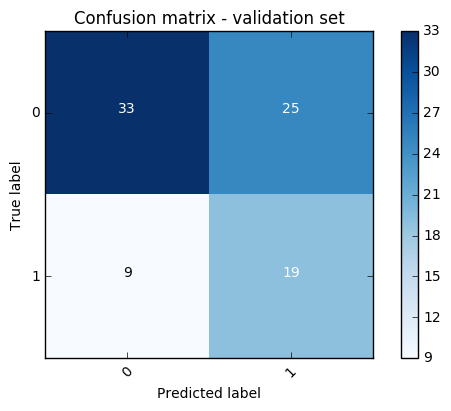

In [190]:
cutOff = 0.5
valCM = getCM(validationLabelsSingle,validationLogits[np.argmax(validationAucs)],cutOff)

plot_confusion_matrix(valCM, classes=[0,1],
                      title='Confusion matrix - validation set')
plt.show()


prediction length:  107
predicted 0's :  106
predicted 1's :  1
Confusion matrix, without normalization
[[77  0]
 [29  1]]


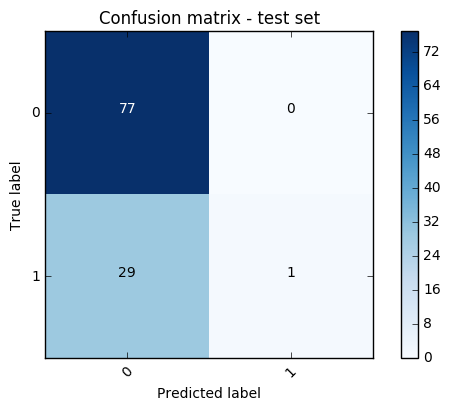

In [168]:
cutOff = 0.5
testCM = getCM(testLabelsSingle,testLogits,cutOff)

plot_confusion_matrix(testCM, classes=[0,1],
                      title='Confusion matrix - test set')
plt.show()

# PLOT CONV FEATURES FROM MODEL

# GET MODEL

In [92]:
# load json and create model
json_file = open('/home/ahmed/Dropbox/DFCI/11_AWS_output/output/' + RUN + '_json.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
myModel = model_from_json(loaded_model_json)
# load weights into new model
myModel.load_weights("/home/ahmed/Dropbox/DFCI/11_AWS_output/output/" + RUN + "_model.h5")

In [93]:
myModel.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_1 (Dense)                  (None, 3)             12          dense_input_4[0][0]              
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 120, 120, 48)  1248        convolution2d_input_10[0][0]     
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 120, 120, 48)  0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 116, 116, 48)  57648       activation_1[0][0]               
___________________________________________________________________________________________

# get Filters - axial/Sag/Cor

In [190]:
def plotFilters(arr):
    fig = plt.figure(figsize=(60,20))
    for i in range (48):
        ax = fig.add_subplot(4,12,i+1)
        ax.imshow  ( arr[:,:,:,i].reshape(5,5) , cmap=plt.cm.binary, interpolation='none') # Greys_r)
        plt.axis('off')
        plt.tight_layout()

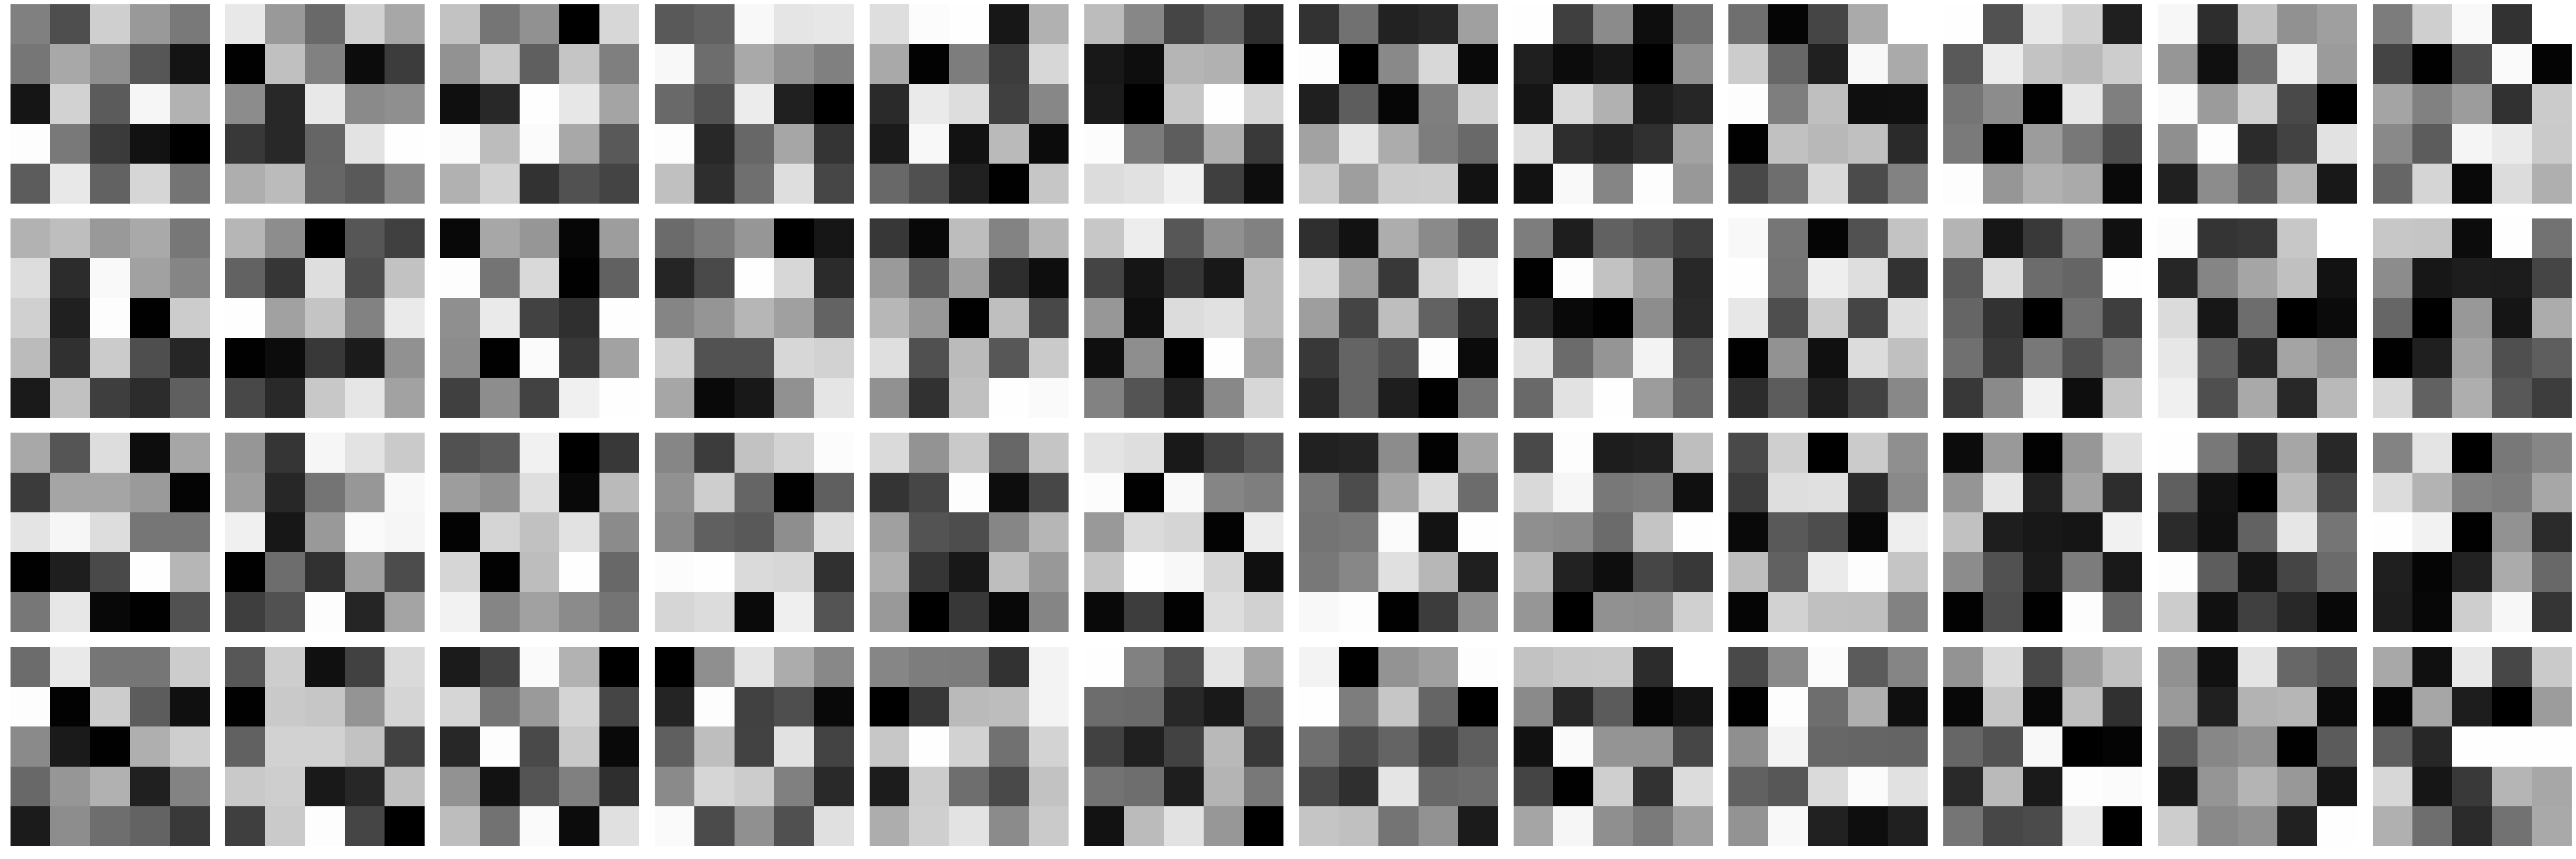

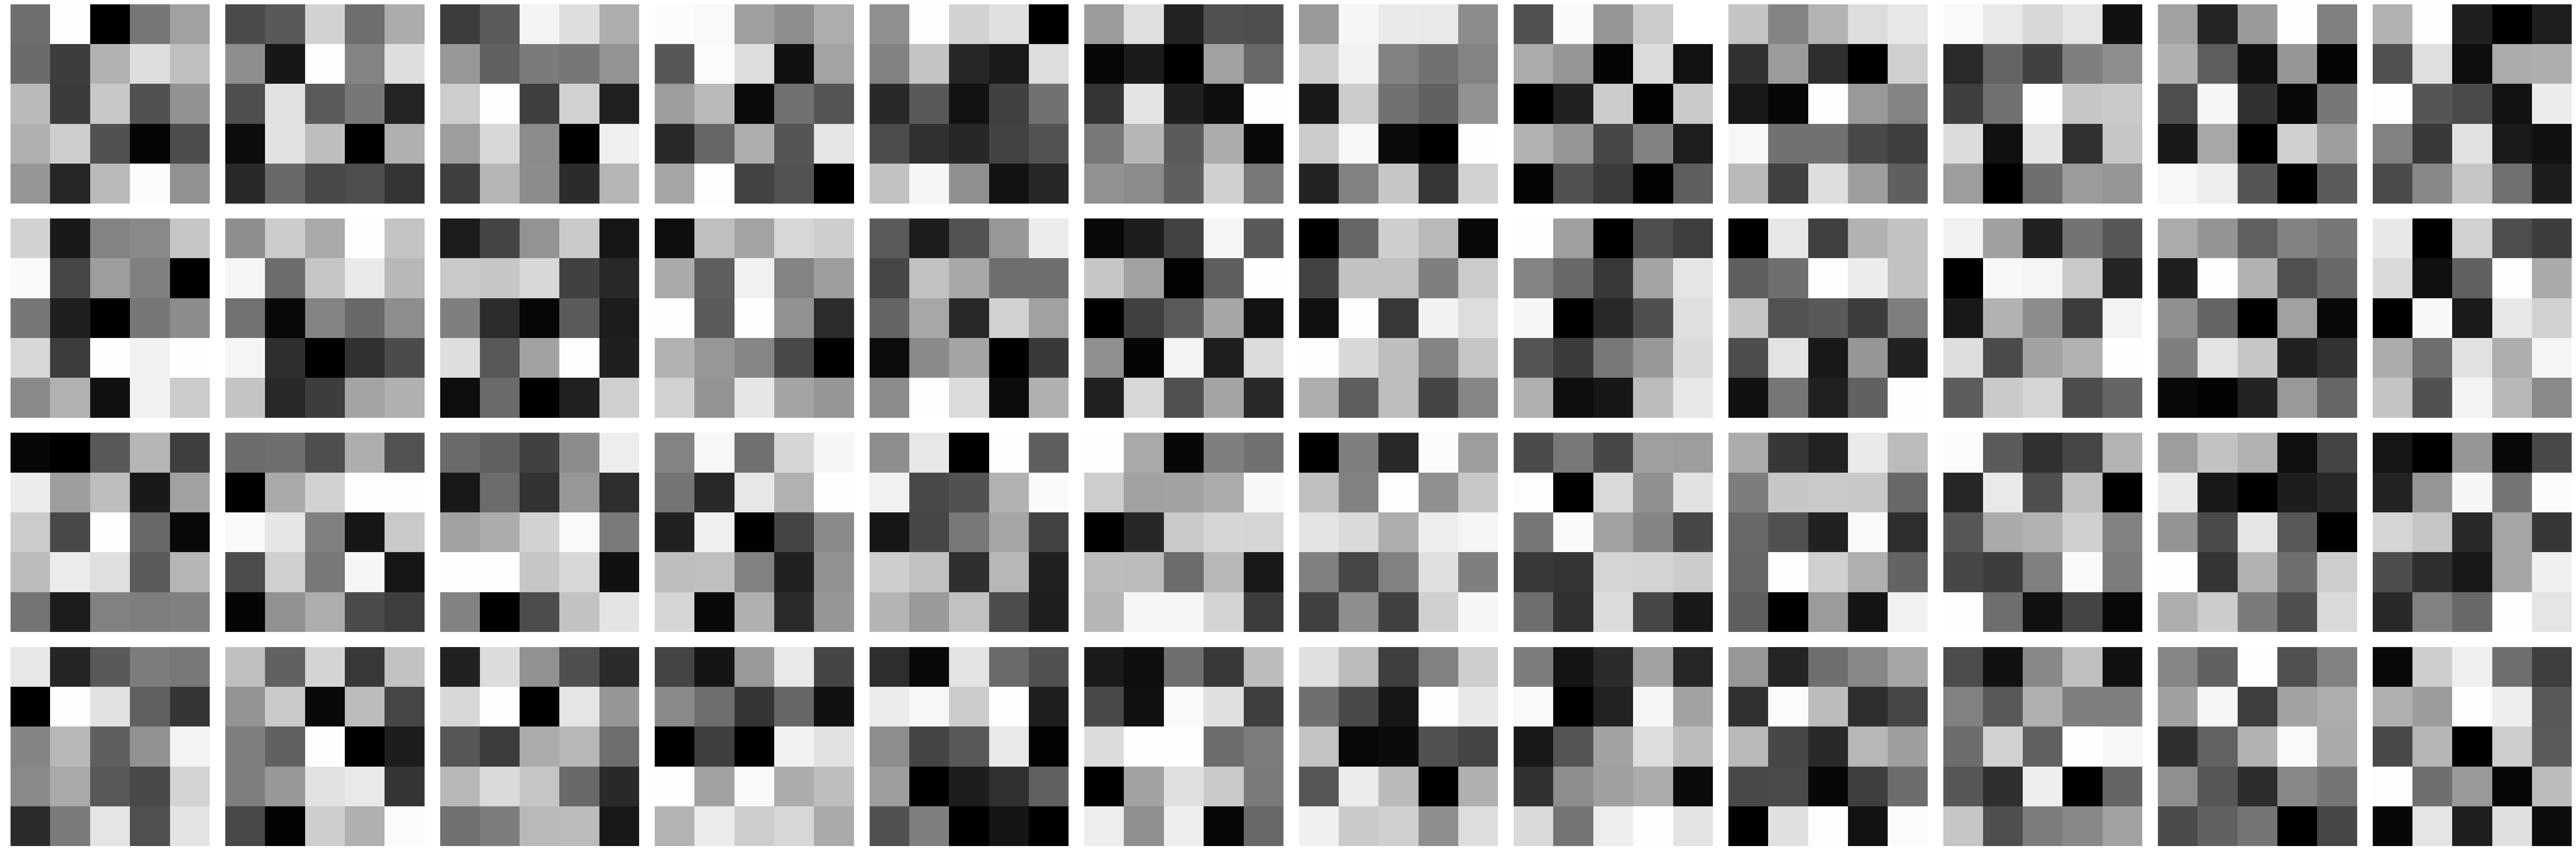

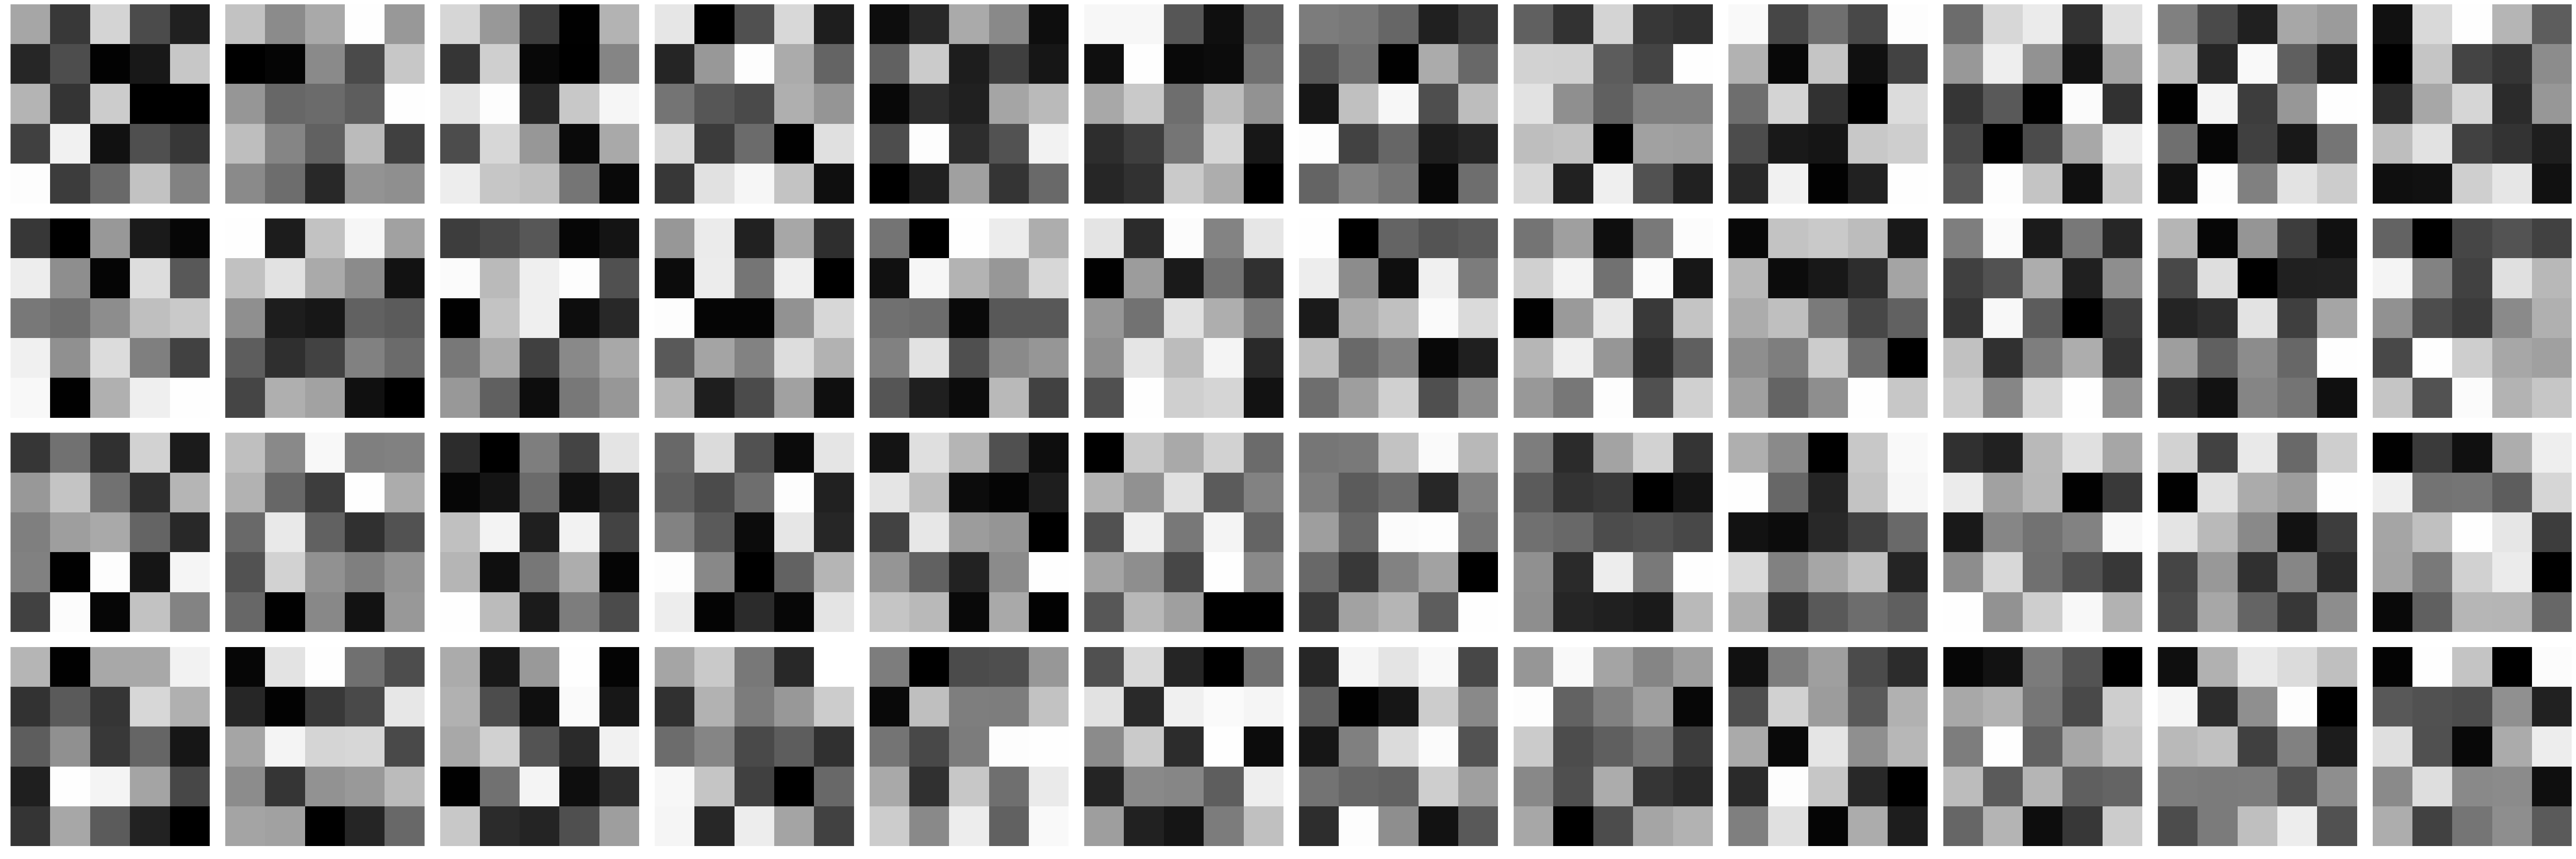

In [191]:
# get filters
# o is filers, 1 is bias vector
conv_1_a = myModel.layers[0].layers[1].layers[0].get_weights()
plotFilters(conv_1_a[0])
#
conv_1_s = myModel.layers[0].layers[2].layers[0].get_weights()
plotFilters(conv_1_s[0])
#
conv_1_c = myModel.layers[0].layers[3].layers[0].get_weights()
plotFilters(conv_1_c[0])

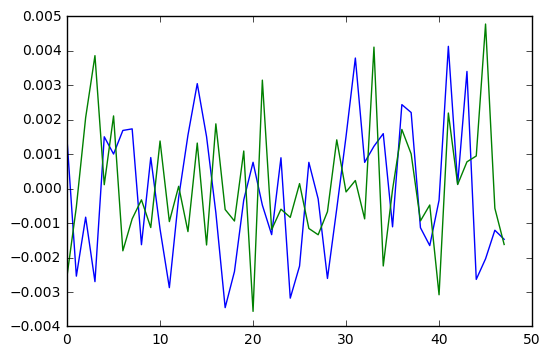

In [202]:
# plt.plot(conv_1_a[1])
plt.plot(conv_1_s[1])
plt.plot(conv_1_c[1])

In [188]:
myModel.layers[0].layers[2].layers

# get Filters - sagittal

(5, 5, 48, 48)


ValueError: total size of new array must be unchanged

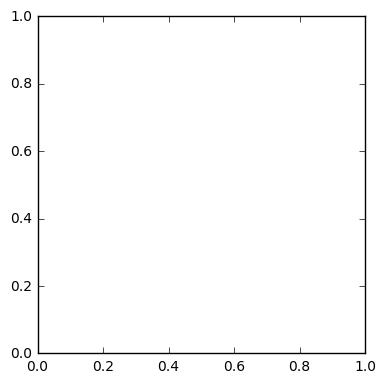

In [180]:
# get filters
conv_1_a = myModel.layers[0].layers[1].layers[2].get_weights()
print conv_1_a[0].shape

fig = plt.figure(figsize=(60,20))
for i in range (48):
    ax = fig.add_subplot(4,12,i+1)
    ax.imshow  ( conv_1_a[0][:,:,:,i].reshape(5,5) , cmap=plt.cm.Greys_r)
    plt.axis('off');
    plt.tight_layout()

In [178]:
myModel.layers[0].layers[1].layers

In [156]:

# conv_1_a.input_shape

In [157]:
plt.imshow  ( conv_1_a [0][:,:,:,21].reshape(5,5) , cmap=plt.cm.Greys_r)
plt.axis('off');

TypeError: 'Activation' object does not support indexing

In [158]:
output_fn = K.function( [conv_1_a.input] , [conv_1_a.output]  )

In [159]:
sample = ["lung1_43062", 'lung1_43421' , 'lung1_43370','lung1_43392' ,'lung1_43402'] 
npy1 = '/home/ahmed/Dropbox/DFCI/kerasLungs/sample/' + sample[0] + '.npy'
arr1 = np.load(npy1)

npy2 = '/home/ahmed/Dropbox/DFCI/kerasLungs/sample/' + sample[1] + '.npy'
arr2 = np.load(npy2)


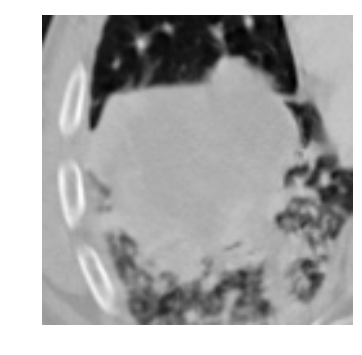

In [160]:
plt.imshow  ( arr1[75,15:135,15:135] , cmap=plt.cm.Greys_r)
plt.axis('off');

In [161]:
ins = np.array( [ arr1[75,15:135,15:135].reshape(120,120,1) ]  )
print ins.shape
outs = output_fn(  [ins] )

(1, 120, 120, 1)


ValueError: Cannot feed value of shape (1, 120, 120, 1) for Tensor u'add_55:0', which has shape '(?, 120, 120, 48)'

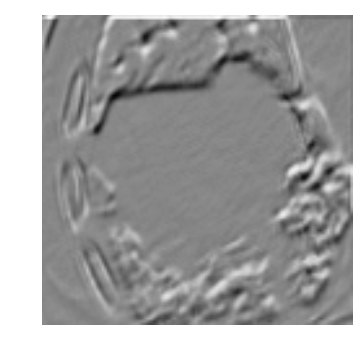

In [137]:

plt.imshow  ( outs[0][0,:,:,30] , cmap=plt.cm.Greys_r)
plt.axis('off');



<module 'matplotlib.pyplot' from '/home/ahmed/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

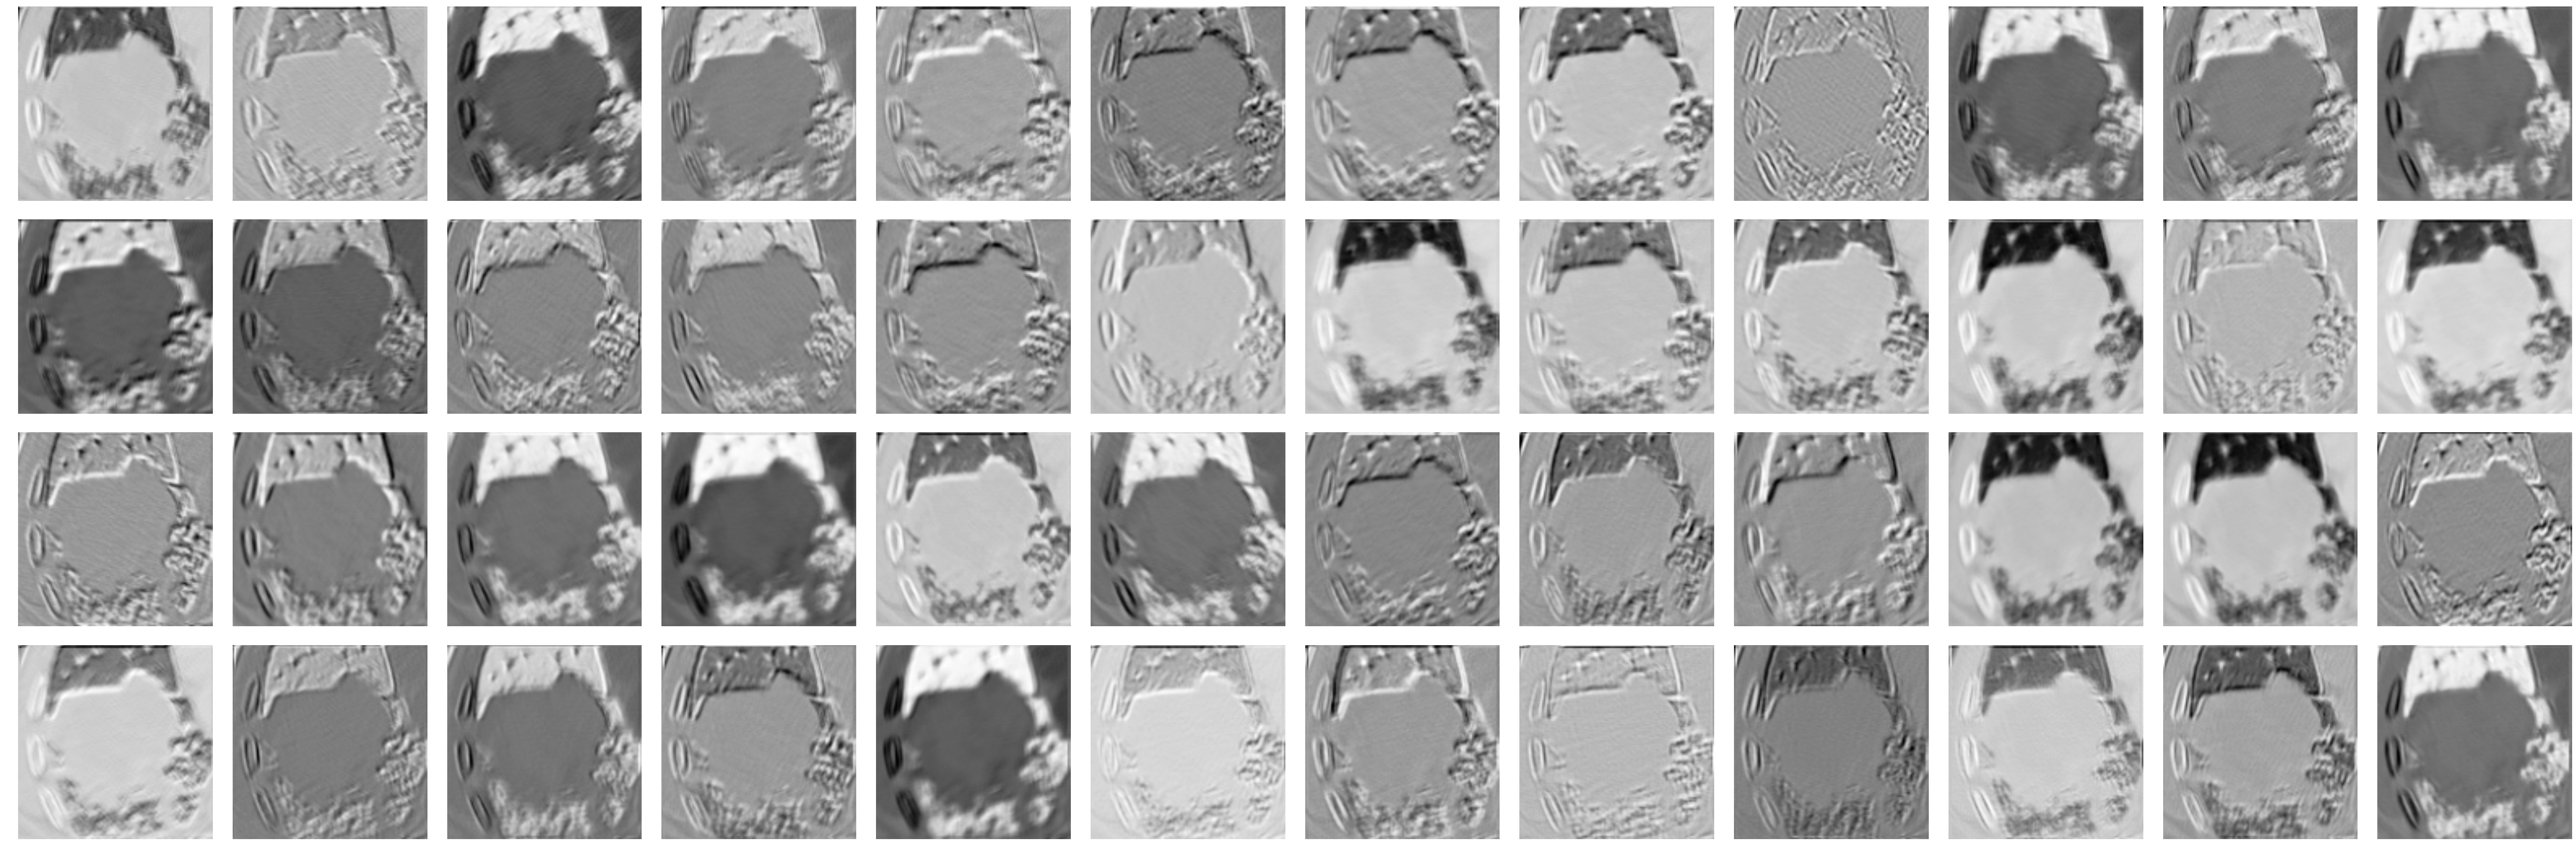

In [153]:
fig = plt.figure(figsize=(60,20))
for i in range (48):
    ax = fig.add_subplot(4,12,i+1)
    ax.imshow  ( outs[0][0,:,:,i] , cmap=plt.cm.Greys_r)
    plt.axis('off');
    plt.tight_layout()
plt

In [ ]:
# get only death by disease
# all patients with cause of death 1
# diseaseDeath = np.load("/home/ahmed/Dropbox/DFCI/kerasLungs/rt_diseaseDeath.npy").astype(str)
# dataFrameTest0 = dataFrameTest[ dataFrameTest['deadstat'] == 0.0 ]
# dataFrameTest1 = dataFrameTest[ dataFrameTest['deadstat'] == 1.0 ]
# dataFrameTest1_1 = dataFrameTest1 [ dataFrameTest1["patient"].isin(diseaseDeath) ]
# dataFrameTest = pd.concat([dataFrameTest0,dataFrameTest1_1],axis=0)
# dataFrameTest = dataFrameTest.reset_index(drop=True)
# print dataFrameTest.shape

# test LR

In [ ]:
lrList = [0.1,0.01,0.001,0.0001,0.00001,0.000001,0.000005,0.0000001,0.0000005,0.00000001 ]

In [13]:
lista = [0.1,0.01,0.001,0.0001,1e-05,1e-06, 5e-06 ]
data = []
boola = "False"
for i in iter(lista):
    seq = np.load("/home/ahmed/Dropbox/DFCI/11_AWS_output/output/tests/" 
                  + str(i) + "_" + boola + "_train_loss.npy").tolist()
    scatter = go.Scatter( x=np.arange(len(seq)), y=seq, 
                      showlegend=True ,line=dict(width=1), name = "lr=" + str(i) )
    data.append(scatter)
    
layout = go.Layout(
    title = "augmentation=" + boola,
    xaxis=dict(
        showgrid=True,
        zeroline=True,
        showline=True,
        showticklabels=True,
        title="epochs"
      
    ),
    yaxis=dict(
        showgrid=True,
        zeroline=True,
        showline=True,
        showticklabels=True,
        title="value",
        range=[0, 5]
    ),
    autosize=True,
    showlegend=True,
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename="run # " ,  ) # image='svg'

In [15]:
lista = [0.001,0.0001,1e-05,1e-06, 5e-06   ] # 0.1,0.01,
data = []
boola = "True"
for i in iter(lista):
    seq = np.load("/home/ahmed/Dropbox/DFCI/11_AWS_output/output/tests/" 
                  + str(i) + "_" + boola + "_train_loss.npy").tolist()
    scatter = go.Scatter( x=np.arange(len(seq)), y=seq, 
                      showlegend=True ,line=dict(width=1), name = "lr=" + str(i) )
    data.append(scatter)
    
layout = go.Layout(
    title = "augmentation=" + boola,
    xaxis=dict(
        showgrid=True,
        zeroline=True,
        showline=True,
        showticklabels=True,
        title="epochs",
        range=[0, 200]
      
    ),
    yaxis=dict(
        showgrid=True,
        zeroline=True,
        showline=True,
        showticklabels=True,
        title="value",
        range=[0, 0.6]
    ),
    autosize=True,
    showlegend=True,
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename="run # " ,  ) # image='svg'